# Sleep classification using wrist-worn accelerometer 

## Data format 
input format: n x 3 x 900

sleep_label: n x 1 

With a sampling frequency of 30hz for tri-axis accelerometer 


## Learning objectives 
1. Sleep prediction using heuristic base method 
2. Sleep parameters derivation 
3. Sleep visualisation 


In terms of sleep data, we will be working with the [Newcastle dataset](https://zenodo.org/record/1160410#.ZAfRby-l1qs), which contains single night of polysomnography (PSG) data in 28 sleep clinic patients.

## AWS info
Run this notebook with the **Data Science** image and **ml.t3.xlarge** instance type.

## 0. Data loading 
Dummy data creation

In [4]:
import numpy as np
import os
%matplotlib inline

In [18]:
prac_root = './'
y_path = os.path.join(prac_root, 'y.npy')
x_path = os.path.join(prac_root, 'X.npy')
times_path = os.path.join(prac_root, 'times.npy')
times = np.load(times_path)
X = np.load(x_path)
y_five_class = np.load(y_path) # every 30-second of PSG was scored into one of the five sleep stages 

In [13]:
X.shape # 1069 epoches 

(1069, 3, 900)

In [19]:
y_five_class

array(['W', 'W', 'W', ..., 'N2', 'W', 'W'], dtype='<U2')

In [64]:
WAKE_LABEL = 0
SLEEP_LABEL = 1

# for simplicity, we will only deal with wake and sleep two classes 
EPOCH_LENGTH = 30
label_dict = {'N1': SLEEP_LABEL,
              'N2': SLEEP_LABEL,
              'N3': SLEEP_LABEL,
              'R': SLEEP_LABEL,
              'W': WAKE_LABEL
            }
sleep_labels = [label_dict[my_class] for my_class in y_five_class]
sleep_labels = np.array(sleep_labels)

In [61]:
np.unique(sleep_labels) # now our sleep labels only contain 0s and 1s 

array([0, 1])

## 1. Sleep prediction 

### 1.1 Simple sleep classifier

In this section, we will try to implement a rule-based method to discriminate wake and sleep. A very naive approach would be relying a vector norm threshold that if the standard deviation is too low, then we will consider an epoch to be in the sleep stage. Formally, provided wtih a tri-axial signal $acc_{xyz} \in R^3$, the threshold method will be the following for some threshold value $\lambda$:

If $ 1/3 * (\sigma_x + \sigma_y + \sigma_z) >= \lambda $, $sleep=FALSE$ 

Otherwise, $sleep=TRUE$

In [27]:
from numpy import linalg as LA

In [47]:
np.std(X[0],axis=1).shape

(3,)

In [54]:
def simple_class_classifier(x, threshold=0.01):
    # x of size 3 by 900
    
    std_axis = np.std(x,axis=1)
    mean_std = np.mean(std_axis)
    
    if mean_std >= threshold:
        return WAKE_LABEL
    else:
        return SLEEP_LABEL

In [55]:
# make classifications using the sample data 
sleep_pred = [simple_class_classifier(my_window) for my_window in X]
sleep_pred = np.array(sleep_pred)

### 1.2 classification evaluation 
Let's compute the sensitivty and specificity against the ground truth 

In [70]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(sleep_labels,
                       sleep_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[ 24  64]
 [173 808]]
Accuracy :  0.7782974742750234
Sensitivity :  0.2727272727272727
Specificity :  0.8236493374108053


### Assignment Custom sleep classifier 
Our current classifier has a high specificity but a low sensitivity. There much be ways that we can improve its performance. Can you try build your own sleep classifier by extracting your own features? 

You might want to explore:
* Relationship between different windows 
* Commonly used spatiotemporal features like mean, frequency and power 
* If you are ambitious enough, there are well-validated rule-based methods that you can try to implement. Refer to [Towards Benchmarked Sleep Detection with Wrist-Worn Sensing Units](https://ieeexplore.ieee.org/document/7052479)

To make things more interesting, we will learn how to make your sleep classifier into a Python package so that millions of people can use your work to help understand their own sleep :D  


## 2. Sleep parameter estimation 

### 2.1 Total sleep time estimate 
Getting total sleep time (tst) is easy because you will only need to count the number of sleep labels in the input array 

In [66]:
def get_tst(my_sleep_labels):
    # output in minutes 
    return np.sum(my_sleep_labels==SLEEP_LABEL) * EPOCH_LENGTH / 60

In [67]:
get_tst(sleep_labels)

490.5

### 2.2 Sleep efficiency

Sleep efficiency (SE) = TST / Time in bed 

In [68]:
def get_se(my_sleep_labels):
    # assuming all the input labels are time in bed 
    timeinbed = len(my_sleep_labels) 
    return get_tst(my_sleep_labels) / timeinbed

In [69]:
get_se(sleep_labels)

0.45884003741814783

### Assignment: implement sleep onset latency (SOL) estimation 

Having seen how to compute total sleep time and sleep efficiency, could you implement the following two functons `get_sleep_onset` and `get_sleep_onset_latency`? 

Q: Do you know what is the SOL for this particular subject? 

### Assignment: Wake after sleep onset estimation 

Q: Do you know what is the WASO for this particular subject? 

## 3. Sleep visulisation 


In [23]:
import seaborn as sns 
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

sns.set_theme(style="darkgrid")


In [24]:
times

array(['2015-04-29T22:04:16.000000000', '2015-04-29T22:04:46.000000000',
       '2015-04-29T22:05:16.000000000', ...,
       '2015-04-30T06:57:16.000000000', '2015-04-30T06:57:46.000000000',
       '2015-04-30T06:58:16.000000000'], dtype='datetime64[ns]')

In [25]:
data2visu = {'times': times,
             'y': sleep_labels}

my_df = pd.DataFrame.from_dict(data2visu)
my_df['times'] = pd.to_datetime(my_df['times'])
my_df.head()

,times,y
0,2015-04-29 22:04:16,0
1,2015-04-29 22:04:46,0
2,2015-04-29 22:05:16,0
3,2015-04-29 22:05:46,0
4,2015-04-29 22:06:16,0


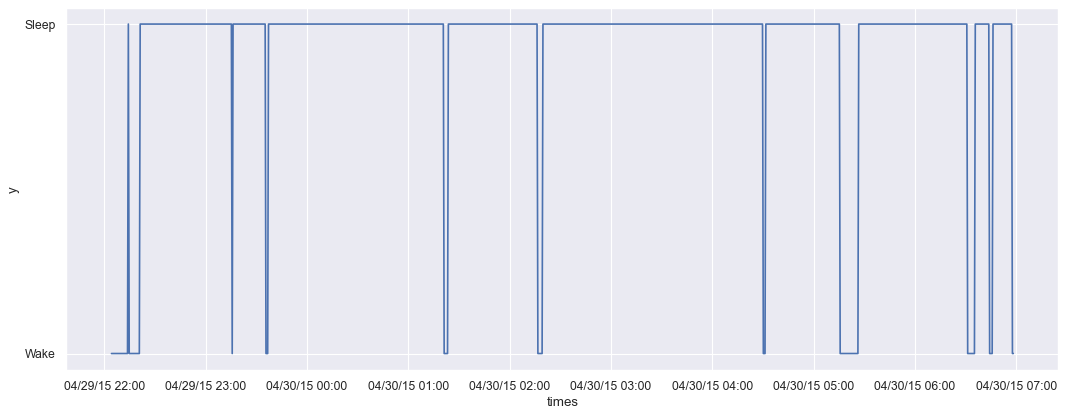

In [26]:
figure(figsize=(16, 6), dpi=80)

ax = sns.lineplot(x="times", y="y",
             data=my_df)
ax.set_yticks([0, 1])
ax.set_yticklabels(("Wake", "Sleep"))


myFmt = mdates.DateFormatter('%D %H:%M') # change timestamp format 
ax.xaxis.set_major_formatter(myFmt)

### Assignment: Better sleep visulisation 

High quality scientific figure is hard, can you try to improve the figure above and perhaps represent other sleep parameters such as SOL and WASO on the figure too enrich the data density? 